In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
from bliss.datasets.pair_sim import generate_pair_dataset

from bliss.datasets.lsst import prepare_final_galaxy_catalog, get_default_lsst_psf
from bliss.reporting import get_residual_measurements, get_deblended_reconstructions

import matplotlib.pyplot as plt
from bliss.catalog import FullCatalog, TileCatalog, turn_samples_into_catalogs
import pytorch_lightning as pl

import torch
import numpy as np 

from tqdm import tqdm

# Loading and organizing

In [ ]:
import torch
import matplotlib.pyplot as plt
from bliss.datasets.lsst import APERTURE_BACKGROUND

In [ ]:
ds =torch.load("../../figures/pair_sim/central_sim_results_7.pt")

In [ ]:
ds.keys()

dict_keys(['outs', 'bld', 'true_snr', 'true_flux', 'true_plocs', 'true_n_sources', 'images'])

In [ ]:
ds['outs'][0].keys()

dict_keys(['nonzero_locs', 'sample_plocs', 'n_sources_samples', 'det_prob', 'sample_fluxes', 'sample_fluxerrs', 'idx', 'n_sources_map', 'map_flux', 'map_fluxerr', 'map_plocs', 'n_sources_sep', 'sep_flux', 'sep_fluxerr', 'sep_plocs'])

In [ ]:
print(len(ds['outs']))
print(ds['bld'].shape)

20000
torch.Size([20000])


In [ ]:
# need to sort things first!!!!
sorted_indices = [out['idx'] for out in ds['outs']]
true_fluxes = ds['true_flux'][sorted_indices][:, 0, 0]
bld = ds['bld'][sorted_indices]
true_snr = ds['true_snr'][sorted_indices][:, 0, 0]
true_fluxes.shape, bld.shape, true_snr.shape

(torch.Size([20000]), torch.Size([20000]), torch.Size([20000]))

In [ ]:
samples_fluxes = torch.stack([out['sample_fluxes'] for out in ds['outs']])
map_fluxes = torch.tensor([out['map_flux'] for out in ds['outs']])
sep_fluxes = torch.tensor([out['sep_flux'] for out in ds['outs']])
samples_fluxes.shape, map_fluxes.shape, true_fluxes.shape, sep_fluxes.shape

(torch.Size([20000, 100]),
 torch.Size([20000]),
 torch.Size([20000]),
 torch.Size([20000]))

In [ ]:
# discard all examples with all NaNs samples 
mask = ~torch.isnan(samples_fluxes).all(dim=1) & (true_snr > 0) # only single galaxy snr < 0
samples_fluxes = samples_fluxes[mask]
map_fluxes = map_fluxes[mask]
sep_fluxes =sep_fluxes[mask]
true_fluxes = true_fluxes[mask]
true_snr = true_snr[mask]
bld = bld[mask]
samples_fluxes.shape, map_fluxes.shape, true_fluxes.shape, true_snr.shape

(torch.Size([19876, 100]),
 torch.Size([19876]),
 torch.Size([19876]),
 torch.Size([19876]))

In [ ]:
true_snr.min()

tensor(0.7272)

# Sanity checks

In [ ]:
# check snr computation?
from bliss.datasets.io import load_dataset_npz
dataset = load_dataset_npz("../../data/datasets/central_sim_dataset_3.npz")

In [ ]:
torch.all(dataset['galaxy_params'][:, 0, -2].ravel()< 25.3)

tensor(True)

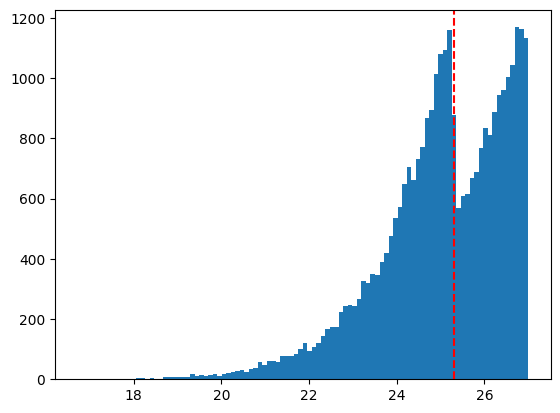

In [ ]:
mags = dataset['galaxy_params'][:, :, -2].ravel()
mask = mags > 0 
plt.hist(mags[mask], bins=100);
plt.axvline(25.3, color='red', linestyle='--')

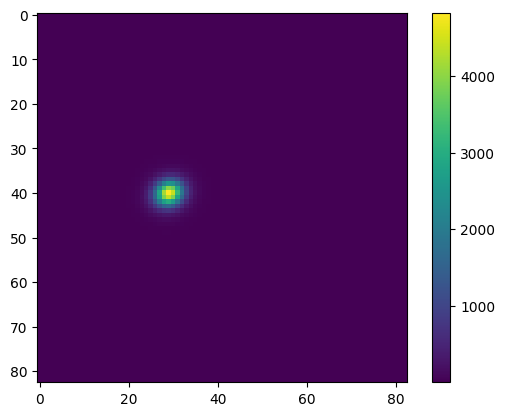

In [ ]:
plt.imshow(dataset['uncentered_sources'][1,2, 0])
plt.colorbar()


In [ ]:
# im1 = ds["uncentered_sources"]
# im2 = ds["uncentered_sources"].sum(dim=1)
# blendedness = get_blendedness(im1, im2)
# assert blendedness.shape == (n_images, max_n_sources)
# bld = blendedness[:, 0]  # only keep central galaxy for now
# assert bld.ndim == 1


In [ ]:
truth = FullCatalog(
    35,
    35,
    {
        "n_sources": dataset["n_sources"],
        "plocs": dataset["plocs"],
        "galaxy_bools": dataset["galaxy_bools"],
    },
)

In [ ]:
true_meas = get_residual_measurements(
    truth,
    dataset["images"],
    paddings=dataset["paddings"],
    sources=dataset["uncentered_sources"],
    no_bar=False,
)

Measuring galaxies: 100%|██████████| 10000/10000 [00:36<00:00, 271.14it/s]


In [ ]:
# snr1 = true_meas['snr'][:, 0, 0]
# mask_plus = snr1 > 0
# mask_minus = snr1 < 0
# plt.hist(snr1[mask_plus].log10(), bins=100, alpha=0.5, label='SNR > 0');
# plt.hist(snr1[mask_minus].abs().log10(), bins=100, alpha=0.5, label='SNR < 0');
# plt.legend()

In [ ]:
# snr1 = true_meas['snr'][:, 0, 0]
# snr2 = true_meas['snr'][:, 1:, 0].ravel()
# mask2 = snr2.abs() > 0 

# plt.hist(snr1.log10(), bins=100, alpha=0.5, label='central', density=True)
# plt.hist(snr2[mask2].log10(), bins=100, alpha=0.5, label='others', density=True)
# plt.xlabel('log10(SNR)')
# plt.legend()

In [ ]:
true_meas['flux'][mask_minus, 0, 0]

tensor([ -144898.9219, -1228899.8750,   -85066.3750,  ...,
         -174337.6406,  -243531.9688,  -138311.6250])

In [ ]:
dataset['uncentered_sources'].shape

torch.Size([10000, 10, 1, 83, 83])

tensor(4)


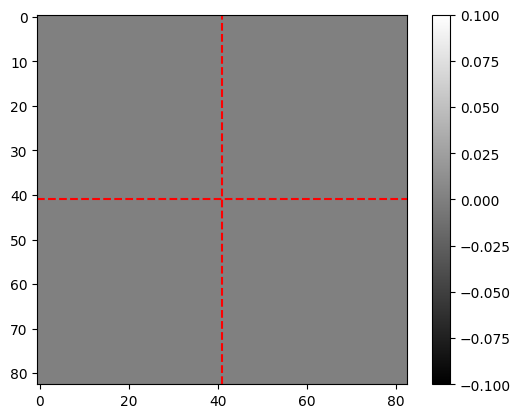

In [ ]:
idx = 11
print(dataset['n_sources'][idx])
image = dataset['images'][idx][0]
other_sources = dataset['uncentered_sources'][idx,5:, 0].sum(0)
padding = dataset['paddings'][idx, 0]
plt.imshow(other_sources, cmap='gray')
plt.colorbar()
plt.axvline(83//2, color='red', linestyle='--')
plt.axhline(83//2, color='red', linestyle='--')

# Histograms

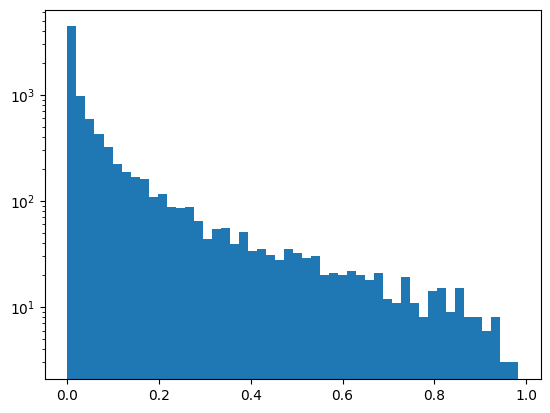

In [ ]:
_mask = bld > 0
plt.hist(bld[_mask], bins=50);
plt.yscale('log')

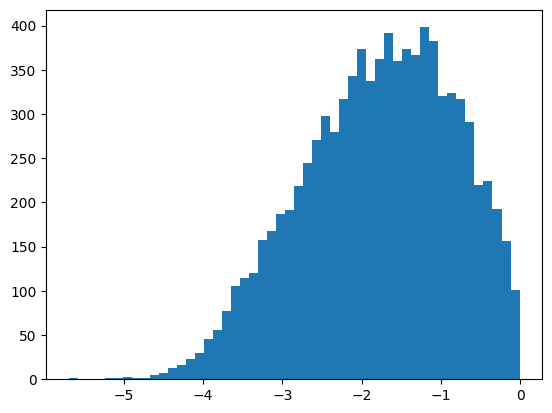

In [ ]:
_mask = bld > 0
plt.hist(bld[_mask].log10(), bins=50);

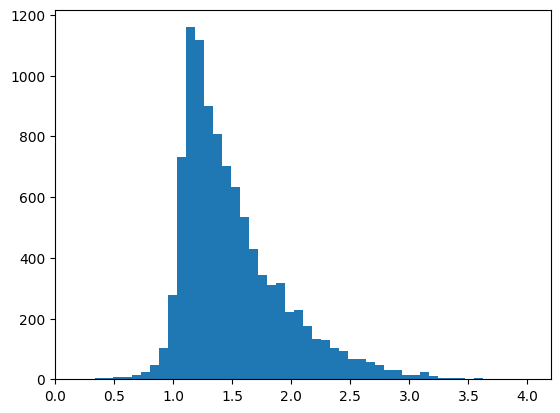

In [ ]:
# snr histogram
plt.hist(true_snr.log10(), bins=50);

In [ ]:
sum(true_snr < 7)

tensor(86)

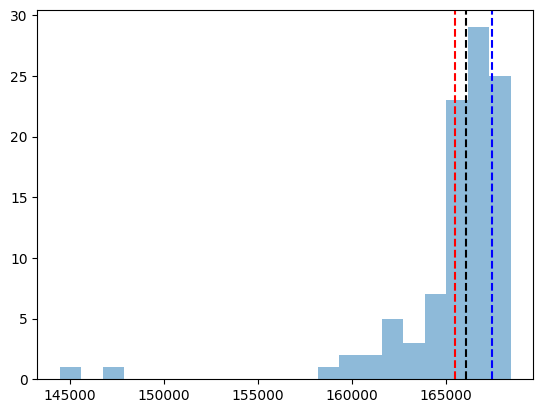

In [ ]:
# check one sample 
idx = 46
plt.hist(samples_fluxes[idx].numpy(), bins=21, alpha=0.5, label='Sample Fluxes')
plt.axvline(samples_fluxes[idx].nanmean().item(), color='red', linestyle='--', label='Mean Sample Flux')
plt.axvline(true_fluxes[idx].item(), color='k', linestyle='--', label='True Flux')
plt.axvline(map_fluxes[idx].item(), color='blue', linestyle='--', label='Map Flux')

In [ ]:
# true snr of all objects
ds['true_snr'].shape

torch.Size([10000, 10, 1])

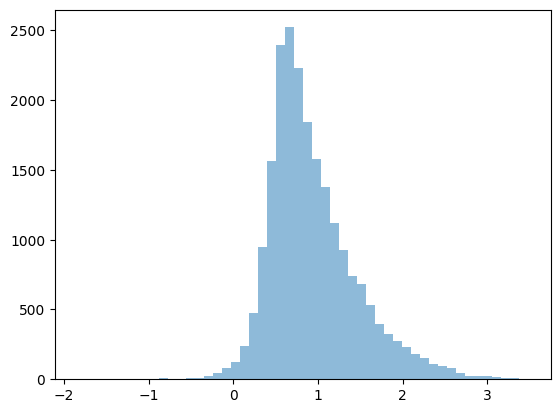

In [ ]:
other_snrs = ds['true_snr'][:, 1:, 0].ravel()
mask = other_snrs > 0
plt.hist(other_snrs[mask].log10(), bins=50, alpha=0.5, label='Other SNRs');

# Preliminary results

In [ ]:
res1 = (samples_fluxes.nanmean(dim=1) - true_fluxes) / (true_fluxes + APERTURE_BACKGROUND)
res2 = (map_fluxes - true_fluxes) / (true_fluxes + APERTURE_BACKGROUND)
res1.shape, res2.shape

(torch.Size([9938]), torch.Size([9938]))

In [ ]:
res1[:10], res1.nanmean()

(tensor([-1.5313e-03, -1.2111e-02, -8.4541e-03,  2.0299e-03, -3.4502e-03,
         -5.8137e-05, -3.1798e-02, -7.9377e-04,  9.9579e-04, -1.7259e-04]),
 tensor(0.0651))

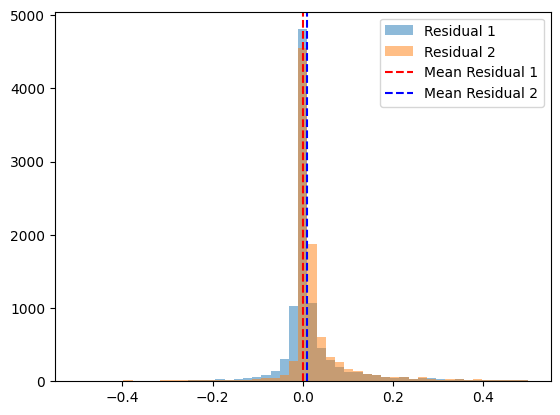

In [ ]:
bins = np.linspace(-0.5, 0.5, 50)

_ = plt.hist(res1, bins=bins, alpha=0.5, label='Residual 1')
plt.hist(res2, bins=bins, alpha=0.5, label='Residual 2')
plt.axvline(res1.nanmedian().item(), color='red', linestyle='--', label='Mean Residual 1')
plt.axvline(res2.nanmedian().item(), color='blue', linestyle='--', label='Mean Residual 2')
plt.legend()

In [ ]:
res1.nanmedian(), res2.nanmedian()

(tensor(0.0011), tensor(0.0086))

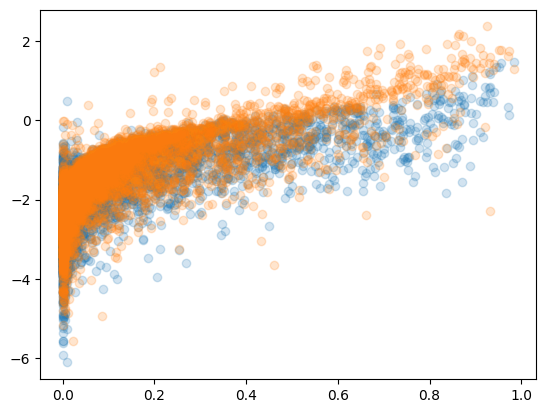

In [ ]:
# as a function of blendedness
plt.scatter(bld, res1.abs().log10(), alpha=0.2, label='Residual 1')
plt.scatter(bld, res2.abs().log10(), alpha=0.2, label='Residual 2')
# plt.ylim(-1, 1)

(-1.0, 1.0)

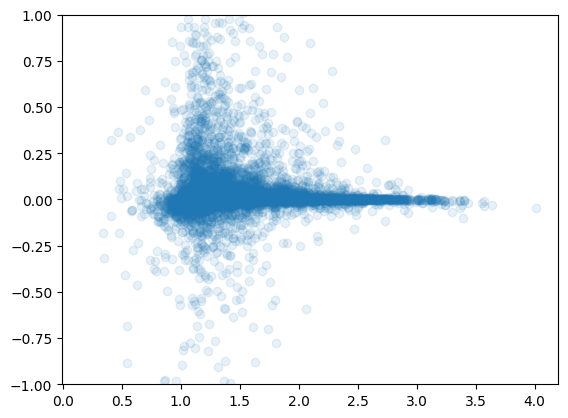

In [ ]:
# snr
plt.scatter(true_snr.log10(), res1, alpha=0.1, label='Residual 1')
plt.ylim(-1, 1)

# Prepare (nans)

In [ ]:
from bliss.plotting import equal_sized_bin_statistic
from bliss.datasets.lsst import APERTURE_BACKGROUND
APERTURE_BACKGROUND = 0.0

In [ ]:
res1 = (samples_fluxes.nanmean(dim=1) - true_fluxes) / (true_fluxes + APERTURE_BACKGROUND)
res2 = (map_fluxes - true_fluxes) / (true_fluxes + APERTURE_BACKGROUND)
res3 = (sep_fluxes - true_fluxes) / (true_fluxes + APERTURE_BACKGROUND)
res1.shape, res2.shape, res3.shape

(torch.Size([19876]), torch.Size([19876]), torch.Size([19876]))

In [ ]:
# res1 = (samples_fluxes.nanmean(dim=1) - true_fluxes) / (true_fluxes )
# res2 = (map_fluxes - true_fluxes) / (true_fluxes )
# res1.shape, res2.shape

In [ ]:
stds = [] 
for ii in range(len(samples_fluxes)):
    mask = ~torch.isnan(samples_fluxes[ii])
    if mask.sum() > 1:
        stds.append(torch.std(samples_fluxes[ii][mask]).item())
    else: 
        stds.append(torch.nan)
stds= torch.tensor(stds)
stds.shape

torch.Size([19876])

In [ ]:
z_score =  (samples_fluxes.nanmean(dim=1) - true_fluxes) / (stds + APERTURE_BACKGROUND)
z_score.shape

torch.Size([19876])

In [ ]:
mask_all = ~torch.isnan(true_snr) & (true_snr > 0) & ~torch.isnan(bld) & ~torch.isnan(res1) & ~torch.isnan(res2) & ~torch.isnan(z_score) & ~torch.isnan(stds) & ~torch.isnan(sep_fluxes)

res1 = res1[mask_all]
res2 = res2[mask_all]
res3 = res3[mask_all]
z_score = z_score[mask_all]
bld = bld[mask_all]
true_snr = true_snr[mask_all]
stds = stds[mask_all]


In [ ]:
map_fluxes.isnan().sum(), stds.isnan().sum(), true_fluxes.isnan().sum(), res1.isnan().sum(), z_score.isnan().sum(), res2.isnan().sum()

(tensor(153), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0))

In [ ]:
sum(bld > 0.7)

tensor(187)

In [ ]:
bld.shape, res1.shape

(torch.Size([19486]), torch.Size([19486]))

# Equally sized bins

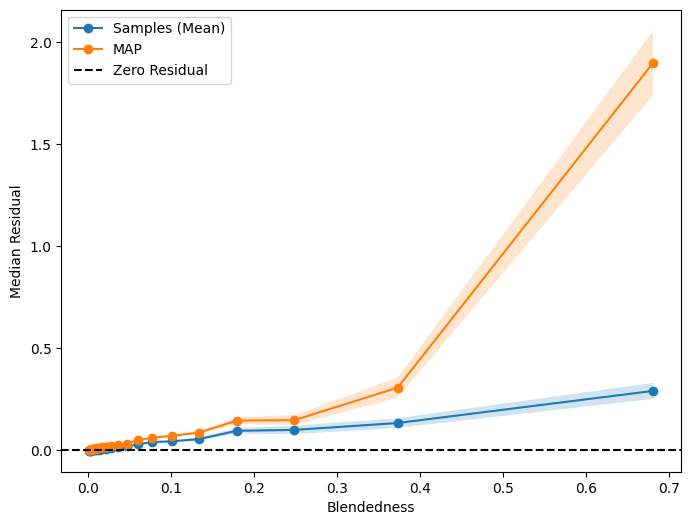

In [ ]:
# same but blendedness (log space)
n_bins = 21
b_dict1_bld = equal_sized_bin_statistic(
    x=bld.log10(),
    y=res1,
    n_bins=n_bins,
    xlims=(-3, 0.0), 
    statistic='median'
)
b_dict2_bld = equal_sized_bin_statistic(
    x=bld.log10(),
    y=res2,
    n_bins=n_bins,
    xlims=(-3, 0.0), 
    statistic='median'
)
plt.figure(figsize=(8, 6))
assert torch.all(b_dict1_bld['middles'] == b_dict2_bld['middles'])

x = 10**b_dict1_bld['middles']

plt.plot(x, b_dict1_bld['stats'], label='Samples (Mean)', marker='o')
plt.fill_between(
    x,
    b_dict1_bld['stats'] - b_dict1_bld['errs'],
    b_dict1_bld['stats'] + b_dict1_bld['errs'],
    alpha=0.2,
)
plt.plot(x, b_dict2_bld['stats'], label='MAP', marker='o')
plt.fill_between(
    x,
    b_dict2_bld['stats'] - b_dict2_bld['errs'],
    b_dict2_bld['stats'] + b_dict2_bld['errs'],
    alpha=0.2,
)
plt.xlabel('Blendedness')
plt.ylabel('Median Residual')
plt.axhline(0, color='k', linestyle='--', label='Zero Residual')
plt.legend()
# plt.xscale('log')
# plt.xlim(10**-2 * 0.5, 1)
# plt.ylim(0, 0.2)
# plt.yscale('log')

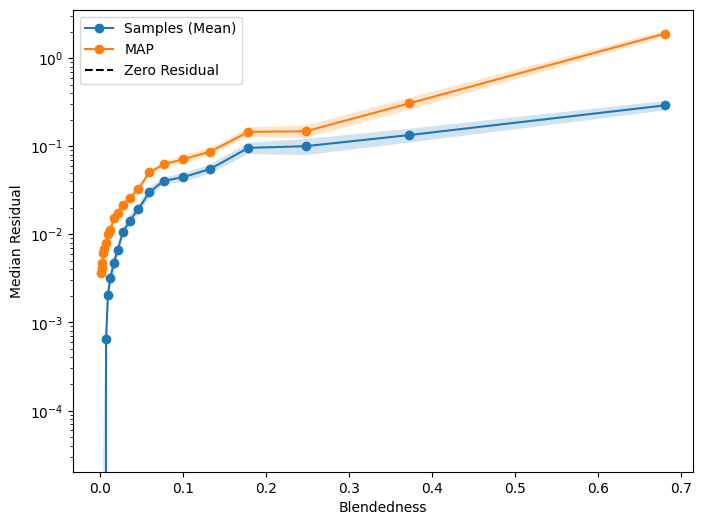

In [ ]:
# same but blendedness (log space)
n_bins = 21
b_dict1_bld = equal_sized_bin_statistic(
    x=bld.log10(),
    y=res1,
    n_bins=n_bins,
    xlims=(-3, 0.0), 
    statistic='median'
)
b_dict2_bld = equal_sized_bin_statistic(
    x=bld.log10(),
    y=res2,
    n_bins=n_bins,
    xlims=(-3, 0.0), 
    statistic='median'
)
plt.figure(figsize=(8, 6))
assert torch.all(b_dict1_bld['middles'] == b_dict2_bld['middles'])

x = 10**b_dict1_bld['middles']

plt.plot(x, b_dict1_bld['stats'], label='Samples (Mean)', marker='o')
plt.fill_between(
    x,
    b_dict1_bld['stats'] - b_dict1_bld['errs'],
    b_dict1_bld['stats'] + b_dict1_bld['errs'],
    alpha=0.2,
)
plt.plot(x, b_dict2_bld['stats'], label='MAP', marker='o')
plt.fill_between(
    x,
    b_dict2_bld['stats'] - b_dict2_bld['errs'],
    b_dict2_bld['stats'] + b_dict2_bld['errs'],
    alpha=0.2,
)
plt.xlabel('Blendedness')
plt.ylabel('Median Residual')
plt.axhline(0, color='k', linestyle='--', label='Zero Residual')
plt.legend()
# plt.xscale('log')
# plt.xlim(10**-2 * 0.5, 1)
# plt.ylim(0, 0.2)
plt.yscale('log')

In [ ]:
b_dict1_bld['counts'], 10**b_dict1_bld['edges'], b_dict1_bld['stats']

(tensor([362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362,
         362, 362, 362, 362, 362, 362, 362], dtype=torch.int32),
 tensor([0.0010, 0.0016, 0.0024, 0.0034, 0.0048, 0.0064, 0.0086, 0.0111, 0.0146,
         0.0191, 0.0244, 0.0316, 0.0409, 0.0528, 0.0673, 0.0874, 0.1152, 0.1535,
         0.2087, 0.2949, 0.4710, 0.9833]),
 tensor([-0.0013, -0.0010, -0.0012, -0.0004, -0.0003,  0.0006,  0.0021,  0.0032,
          0.0047,  0.0067,  0.0106,  0.0143,  0.0195,  0.0300,  0.0406,  0.0446,
          0.0554,  0.0961,  0.1004,  0.1342,  0.2916]))

In [ ]:
b_dict1_bld['errs']

tensor([0.0003, 0.0005, 0.0004, 0.0004, 0.0005, 0.0005, 0.0007, 0.0007, 0.0014,
        0.0010, 0.0013, 0.0024, 0.0026, 0.0041, 0.0038, 0.0052, 0.0068, 0.0141,
        0.0210, 0.0239, 0.0366])

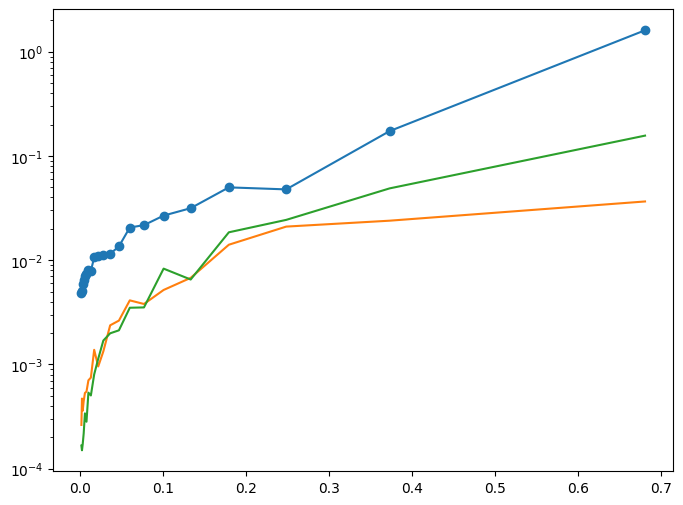

In [ ]:
# plot difference 
plt.figure(figsize=(8, 6))
plt.plot(x, b_dict2_bld['stats'] - b_dict1_bld['stats'] , label='Samples - MAP', marker='o')
plt.plot(x, b_dict1_bld['errs'] )
plt.plot(x, b_dict2_bld['errs'])
plt.yscale('log')

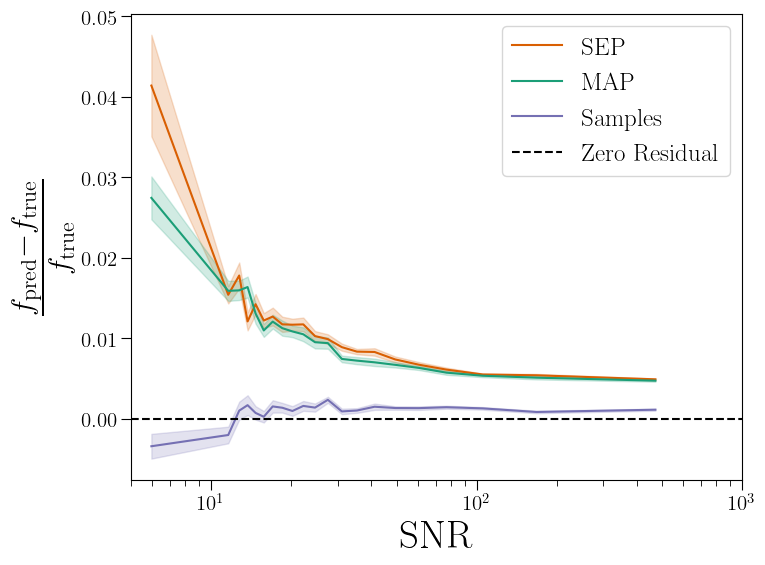

In [ ]:
from bliss.plotting import set_rc_params, CLR_CYCLE
set_rc_params()

# now snr 
n_bins = 21
out1 = equal_sized_bin_statistic(
    x=true_snr.log10(),
    y=res1,
    n_bins=n_bins,
    xlims=(0.5, 3), 
    statistic='median'
)
out2 = equal_sized_bin_statistic(
    x=true_snr.log10(),
    y=res2,
    n_bins=n_bins,
    xlims=(0.5, 3), 
    statistic='median'
)
out3 = equal_sized_bin_statistic(
    x=true_snr.log10(),
    y=res3,
    n_bins=n_bins,
    xlims=(0.5, 3), 
    statistic='median'
)
assert torch.all(out1['middles'] == out2['middles'])
x = 10**out1['middles']


plt.figure(figsize=(8, 6))
plt.plot(x, out3['stats'], label=r'\rm SEP', marker='', color=CLR_CYCLE[2])
plt.fill_between(
    x,
    out3['stats'] - out3['errs'],
    out3['stats'] + out3['errs'],
    alpha=0.2,
    color=CLR_CYCLE[2],
)
plt.plot(x, out2['stats'], label=r'\rm MAP', marker='', color=CLR_CYCLE[0])
plt.fill_between(
    x,
    out2['stats'] - out2['errs'],
    out2['stats'] + out2['errs'],
    alpha=0.2,
    color=CLR_CYCLE[0],
)
plt.plot(x, out1['stats'], label=r'\rm Samples', marker='', color=CLR_CYCLE[1])
plt.fill_between(
   x,
    out1['stats'] - out1['errs'],
    out1['stats'] + out1['errs'],
    alpha=0.2,
    color=CLR_CYCLE[1],
)
plt.xlabel(r'\rm SNR', fontsize=28)
plt.ylabel(r'$\frac{f_{\rm pred} - f_{\rm true}}{f_{\rm true}}$', fontsize=32)
plt.axhline(0, color='k', linestyle='--', label=r'\rm Zero Residual')
plt.legend()
plt.xlim(5, 1000)
plt.xscale('log')
plt.savefig('samples_snr_res.png', dpi=500, bbox_inches='tight')

In [ ]:
out1['counts']

tensor([923, 923, 922, 923, 922, 923, 922, 923, 922, 923, 922, 923, 922, 923,
        922, 923, 922, 923, 922, 923, 922], dtype=torch.int32)

In [ ]:
out1['edges']

tensor([0.5097, 1.0371, 1.0889, 1.1232, 1.1528, 1.1828, 1.2118, 1.2460, 1.2824,
        1.3240, 1.3648, 1.4120, 1.4602, 1.5171, 1.5738, 1.6421, 1.7259, 1.8323,
        1.9457, 2.1044, 2.3615, 2.9995])

In [ ]:
blds_medians = [] 
counts = [] 
for ii in range(len(b_dict1_snr['edges']) - 1):
    e1 = b_dict1_snr['edges'][ii]
    e2 = b_dict1_snr['edges'][ii + 1]
    mask = (true_snr.log10() > e1) & (true_snr.log10() < e2)
    counts.append(mask.sum().item())
    blds_medians.append(bld[mask].nanmedian().item())


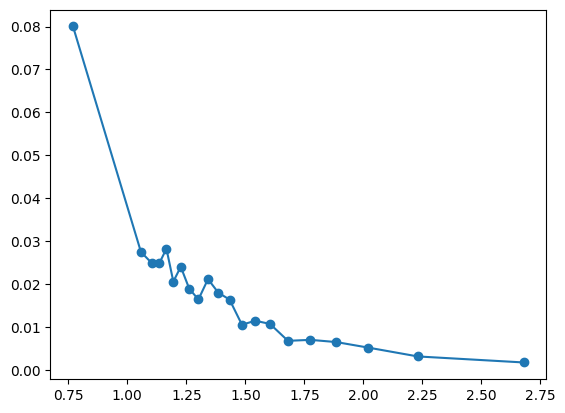

In [ ]:
plt.plot(b_dict1_snr['middles'], blds_medians, marker='o')

# Custom bins

In [ ]:
from bliss.plotting import equal_sized_bin_statistic, binned_statistic

In [ ]:
bins = torch.tensor([0.0, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 1.0])
out1 = binned_statistic(
    x=bld,
    y=res1,
    bins=bins,
    statistic='median',
)

out2 = binned_statistic(
    x=bld,
    y=res2,
    bins=bins,
    statistic='median',
)

In [ ]:
out1['counts']

tensor([6840,  997,  837,  430,  240,  154,  122,  194], dtype=torch.int32)

Text(0.5, 0, 'Blendedness')

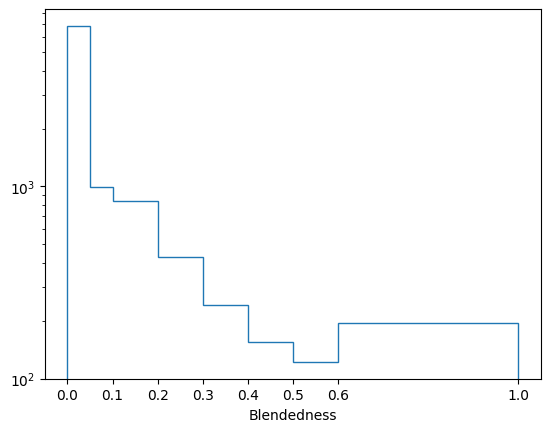

In [ ]:
plt.stairs(values=out1['counts'], edges=out1['edges'])
# plt.stairs(values=out2['counts'], edges=out2['edges'])
plt.yscale('log')
plt.xticks([bins[0], *bins[2:]]);
plt.xlabel('Blendedness')

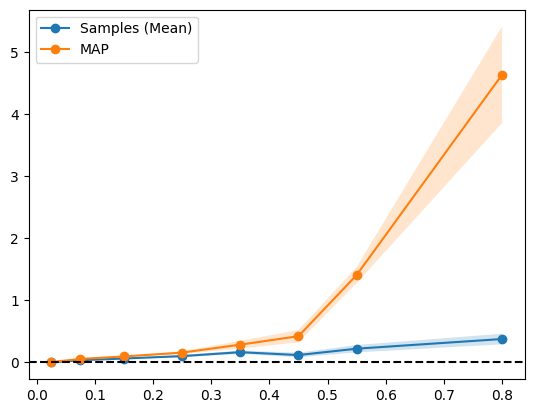

In [ ]:
x = out1['middles']
plt.plot(x, out1['stats'], label='Samples (Mean)', marker='o')
plt.fill_between(
    x,
    out1['stats'] - out1['errs'],
    out1['stats'] + out1['errs'],
    alpha=0.2,
)

plt.plot(x, out2['stats'], label='MAP', marker='o')
plt.fill_between(
    x,
    out2['stats'] - out2['errs'],
    out2['stats'] + out2['errs'],
    alpha=0.2,
)
plt.legend()
plt.axhline(0.0, color='k', linestyle='--')
# plt.yscale('log')

# Equally spaced except the last one

In [ ]:
from bliss.plotting import equal_sized_bin_statistic, binned_statistic

In [ ]:
bld.quantile(0.12).item()

4.835128493141383e-05

In [ ]:
qs = torch.linspace(0.12, 0.99, 31)
edges = bld.quantile(qs)
edges = [e.item() for e in edges]
edges

[4.835128493141383e-05,
 0.00024538012803532183,
 0.00046668120194226503,
 0.0007355088018812239,
 0.0011052072513848543,
 0.001586348284035921,
 0.0021699867211282253,
 0.0028407142963260412,
 0.0037740799598395824,
 0.004863022826611996,
 0.006137183401733637,
 0.007633084896951914,
 0.009522401727735996,
 0.011909561231732368,
 0.014684093184769154,
 0.017978902906179428,
 0.022148946300148964,
 0.02671228162944317,
 0.03241296857595444,
 0.03955609351396561,
 0.0479159951210022,
 0.058397822082042694,
 0.07191147655248642,
 0.08794505149126053,
 0.10963685810565948,
 0.13591386377811432,
 0.17567101120948792,
 0.22951218485832214,
 0.3017154037952423,
 0.4355751574039459,
 0.6923412680625916]

In [ ]:
bins = torch.tensor([0.0, *edges[1:-1],1.0])
bins.shape

torch.Size([31])

In [ ]:
from bliss.plotting import set_rc_params, CLR_CYCLE
set_rc_params()

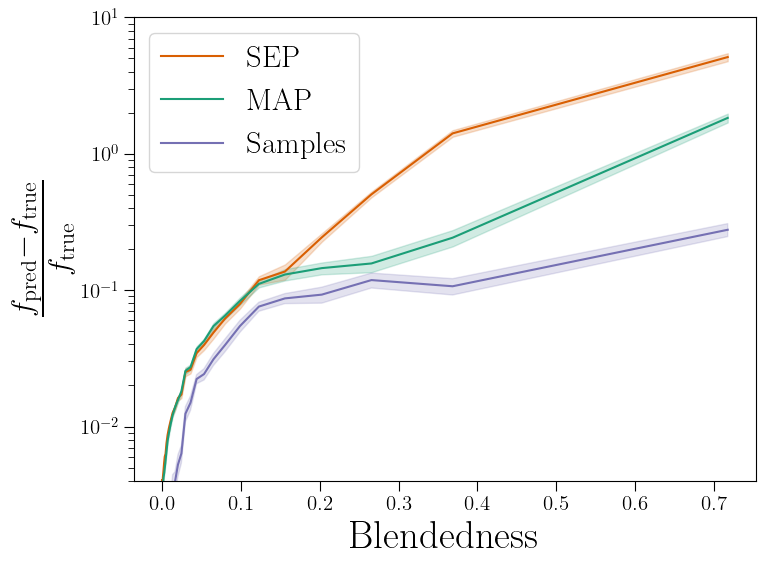

In [ ]:


out1 = binned_statistic(
    x=bld,
    y=res1,
    bins=bins,
    statistic='median',
)
out2 = binned_statistic(
    x=bld,
    y=res2,
    bins=bins,
    statistic='median',
)
out3 = binned_statistic(
    x=bld,
    y=res3,
    bins=bins,
    statistic='median',
)
plt.figure(figsize=(8, 6))
plt.plot(out3['middles'], out3['stats'], label=r'\rm SEP', marker='', color=CLR_CYCLE[2])
plt.fill_between(
    out3['middles'],
    out3['stats'] - out3['errs'],
    out3['stats'] + out3['errs'],
    alpha=0.2,
    color=CLR_CYCLE[2],
)
plt.plot(out2['middles'], out2['stats'], label=r'\rm MAP', marker='', color=CLR_CYCLE[0])
plt.fill_between(
    out2['middles'],
    out2['stats'] - out2['errs'],
    out2['stats'] + out2['errs'],
    alpha=0.2,
    color=CLR_CYCLE[0],
)
plt.plot(out1['middles'], out1['stats'], label=r'\rm Samples', marker='', color=CLR_CYCLE[1])
plt.fill_between(
    out1['middles'],
    out1['stats'] - out1['errs'],
    out1['stats'] + out1['errs'],
    alpha=0.2,
    color=CLR_CYCLE[1],
)
plt.xlabel(r'\rm Blendedness', fontsize=28)
plt.ylabel(r'$\frac{f_{\rm pred} - f_{\rm true}}{f_{\rm true}}$', fontsize=32)
# plt.axhline(0, color='k', linestyle='--', label='Zero Residual')
plt.yscale('log')
plt.ylim(0.004, 10)
plt.legend(prop={'size':22})
plt.savefig('samples_bld_res.png', dpi=500, bbox_inches='tight')

In [ ]:
out1['edges'], out1['counts'], out1['stats']

(tensor([0.0000e+00, 2.4538e-04, 4.6668e-04, 7.3551e-04, 1.1052e-03, 1.5863e-03,
         2.1700e-03, 2.8407e-03, 3.7741e-03, 4.8630e-03, 6.1372e-03, 7.6331e-03,
         9.5224e-03, 1.1910e-02, 1.4684e-02, 1.7979e-02, 2.2149e-02, 2.6712e-02,
         3.2413e-02, 3.9556e-02, 4.7916e-02, 5.8398e-02, 7.1911e-02, 8.7945e-02,
         1.0964e-01, 1.3591e-01, 1.7567e-01, 2.2951e-01, 3.0172e-01, 4.3558e-01,
         1.0000e+00]),
 tensor([2904,  565,  565,  565,  565,  565,  565,  565,  565,  565,  565,  565,
          566,  565,  565,  565,  565,  565,  565,  565,  565,  565,  565,  565,
          565,  565,  565,  566,  565,  760], dtype=torch.int32),
 tensor([-1.7306e-03, -8.7118e-04, -8.8067e-04, -1.2390e-03, -1.0986e-03,
         -9.2141e-04, -1.0025e-03, -9.3828e-04, -6.7140e-04,  8.4419e-05,
          4.6890e-04,  7.2691e-04,  2.4099e-03,  3.8525e-03,  3.9418e-03,
          5.2556e-03,  6.3444e-03,  1.2420e-02,  1.4940e-02,  2.2306e-02,
          2.4244e-02,  3.1156e-02,  3.9668e-02, 

In [ ]:
out2['stats']

tensor([0.0033, 0.0031, 0.0035, 0.0035, 0.0039, 0.0043, 0.0045, 0.0050, 0.0056,
        0.0066, 0.0078, 0.0090, 0.0104, 0.0121, 0.0138, 0.0157, 0.0181, 0.0256,
        0.0273, 0.0370, 0.0424, 0.0545, 0.0651, 0.0833, 0.1112, 0.1302, 0.1451,
        0.1569, 0.2425, 1.8327])

In [ ]:
out3['stats']

tensor([4.0445e-03, 3.9549e-03, 3.9550e-03, 4.2433e-03, 4.5027e-03, 4.8888e-03,
        5.4251e-03, 6.0226e-03, 6.3135e-03, 7.5534e-03, 8.6637e-03, 9.7402e-03,
        1.1012e-02, 1.2609e-02, 1.3764e-02, 1.6155e-02, 1.7169e-02, 2.5084e-02,
        2.6086e-02, 3.4511e-02, 3.9614e-02, 4.8871e-02, 6.1942e-02, 7.9189e-02,
        1.1827e-01, 1.3687e-01, 2.4372e-01, 5.0388e-01, 1.4109e+00, 5.1174e+00])

# Histogram z-scores

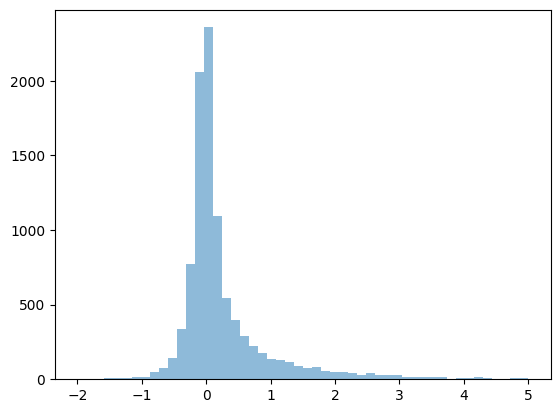

In [ ]:
plt.hist(z_score.numpy(), bins=50, alpha=0.5, label='Z-score of Sample Fluxes', range=(-2, 5));

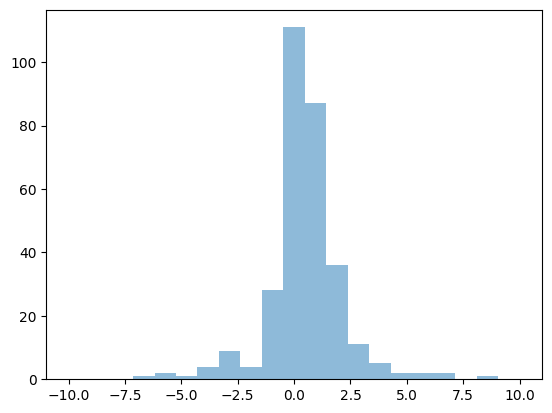

In [ ]:
_mask = bld > 0.5
plt.hist(z_score[_mask].numpy(), bins=21, alpha=0.5, range=(-10, 10));

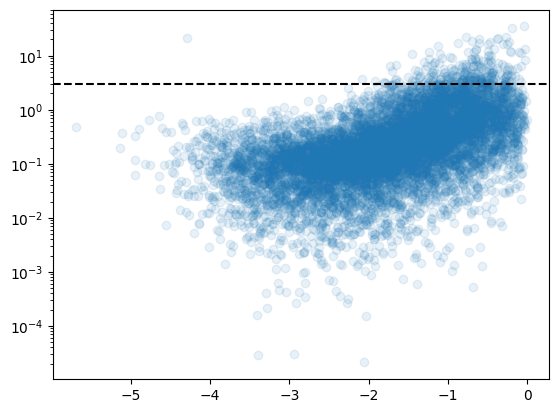

In [ ]:
plt.scatter(bld.log10(), z_score.abs(), alpha=0.1, label='Z-score vs Blendedness')
plt.axhline(3, color='k', linestyle='--', label='Z-score = 3')
# plt.axhline(-3, color='k', linestyle='--', label='Z-score = -3')
# plt.ylim(-5, 5)
plt.yscale('log')

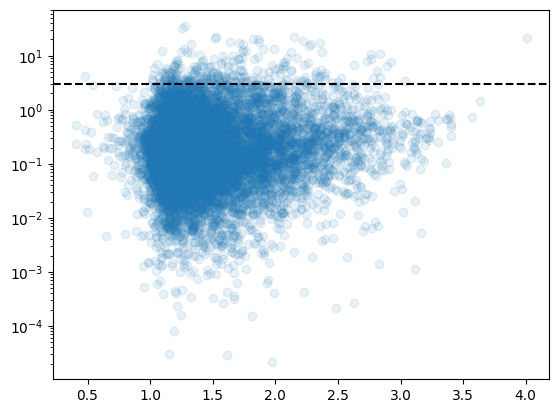

In [ ]:
plt.scatter(true_snr.log10(), z_score.abs(), alpha=0.1, label='Z-score vs SNR')
plt.axhline(3, color='k', linestyle='--', label='Z-score = 3')
plt.yscale('log')
# plt.axhline(-3, color='k', linestyle='--', label='Z-score = -3')

# 

# Some separate histograms of residuals

In [ ]:
bld.shape, res1.shape, res2.shape

(torch.Size([9814]), torch.Size([9814]), torch.Size([9814]))

tensor(316)

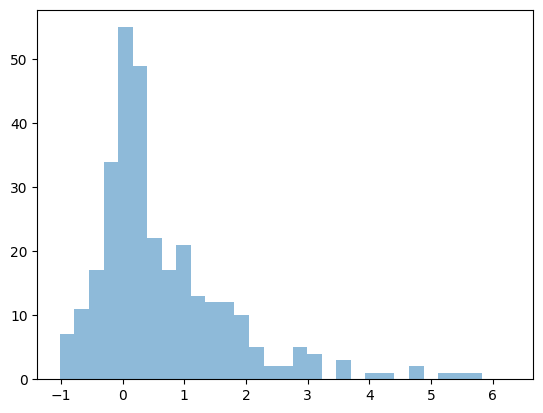

In [ ]:
_mask = bld  > 0.5
x = res1[_mask].numpy()
q1, q2 = np.percentile(x, [1, 99])
bins = 31
plt.hist(x, bins=31, alpha=0.5, label='Residual 1 (Blendedness > 0.5', range=(q1, q2));
sum(_mask)

tensor(316)

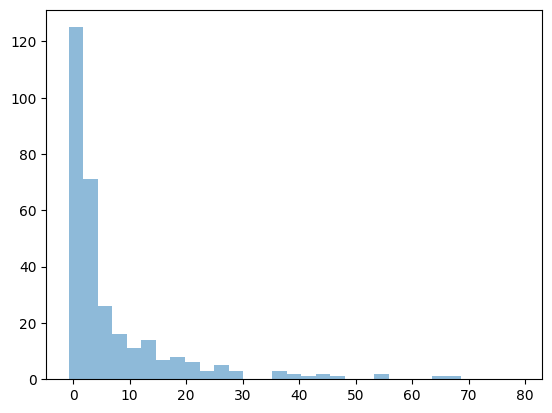

In [ ]:
_mask = bld  > 0.5
x = res2[_mask].numpy()
q1, q2 = np.percentile(x, [1, 99])
bins = 31
plt.hist(x, bins=31, alpha=0.5, label='Residual 1 (Blendedness > 0.5', range=(q1, q2));
sum(_mask)

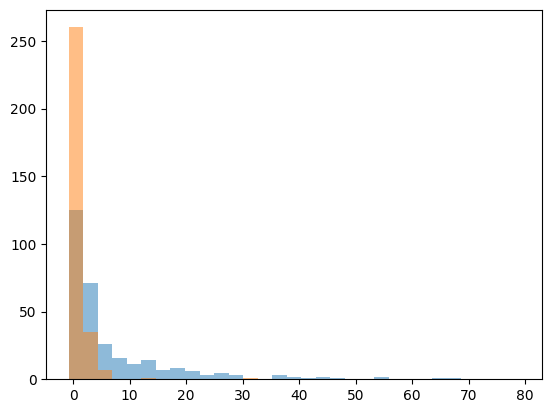

In [ ]:
_mask = (bld > 0.5)
x1 = res1[_mask].numpy()
x2 = res2[_mask].numpy()
q1, q2 = np.percentile(x2, [1, 99])
_, bins, _ = plt.hist(x2, bins=31, alpha=0.5, label='Residual 2 (Blendedness > 0.1)', range=(q1, q2));
plt.hist(x1, bins=bins, alpha=0.5, label='Residual 1 (Blendedness > 0.1)', range=(q1, q2));
# bins = np.linspace(-5, 20, 31)

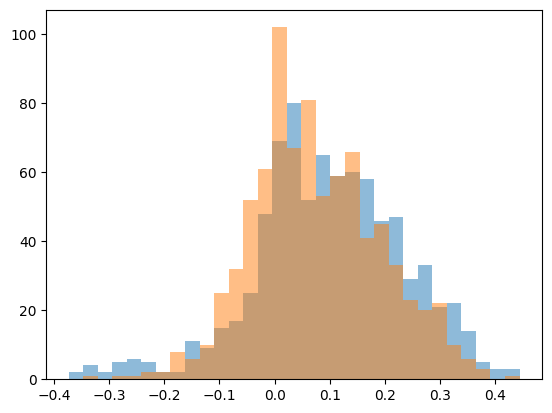

In [ ]:
_mask = (bld > 0.1) & (bld < 0.2)
x1 = res1[_mask].numpy()
x2 = res2[_mask].numpy()
q1, q2 = np.percentile(x2, [1, 99])
_, bins, _ = plt.hist(x2, bins=31, alpha=0.5, label='Residual 2 (Blendedness > 0.1)', range=(q1, q2));
plt.hist(x1, bins=bins, alpha=0.5, label='Residual 1 (Blendedness > 0.1)', range=(q1, q2));
# bins = np.linspace(-5, 20, 31)

tensor(430)

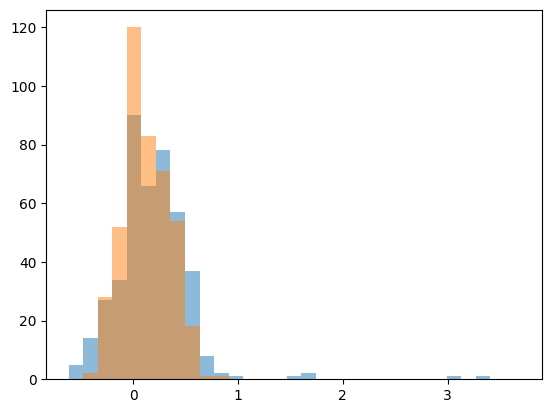

In [ ]:
_mask = (bld > 0.2) & (bld < 0.3)
x1 = res1[_mask].numpy()
x2 = res2[_mask].numpy()
q1, q2 = np.percentile(x2, [0.5, 99.5])
_, bins, _ = plt.hist(x2, bins=31, alpha=0.5, label='Residual 2 (Blendedness > 0.1)', range=(q1, q2));
plt.hist(x1, bins=bins, alpha=0.5, label='Residual 1 (Blendedness > 0.1)')
# bins = np.linspace(-5, 20, 31)
sum(_mask)

tensor(394)

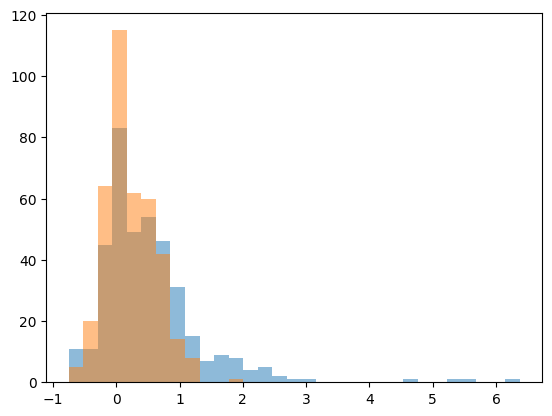

In [ ]:
_mask = (bld > 0.3) & (bld < 0.5)
x1 = res1[_mask].numpy()
x2 = res2[_mask].numpy()
q1, q2 = np.percentile(x2, [1, 99])
_, bins, _ = plt.hist(x2, bins=31, alpha=0.5, label='Residual 2 (Blendedness > 0.1)', range=(q1, q2));
plt.hist(x1, bins=bins, alpha=0.5, label='Residual 1 (Blendedness > 0.1)')
# bins = np.linspace(-5, 20, 31)
sum(_mask)

tensor(9498)

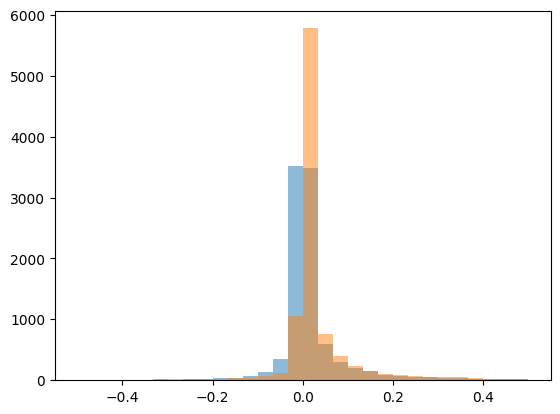

In [ ]:
_mask = bld  < 0.5
bins = np.linspace(-0.5, 0.5, 31)
plt.hist(res1[_mask].numpy(), bins=bins, alpha=0.5, label='Residual 1 (Blendedness > 0.7');
plt.hist(res2[_mask].numpy(), bins=bins, alpha=0.5, label='Residual 2 (Blendedness > 0.7');
sum(_mask)